In [3]:
import h5py
import numpy as np
from tqdm import tqdm
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

from orbit_evolution_potential import NFW, LeepFrog, Rx, Ry, Rz, run
from dynesty_NestedSampling import model, get_gamma, log_likelihood_density, prior_transform, generate_data, log_likelihood_GMM, log_likelihood_phi

Text(0, 0.5, '$y$')

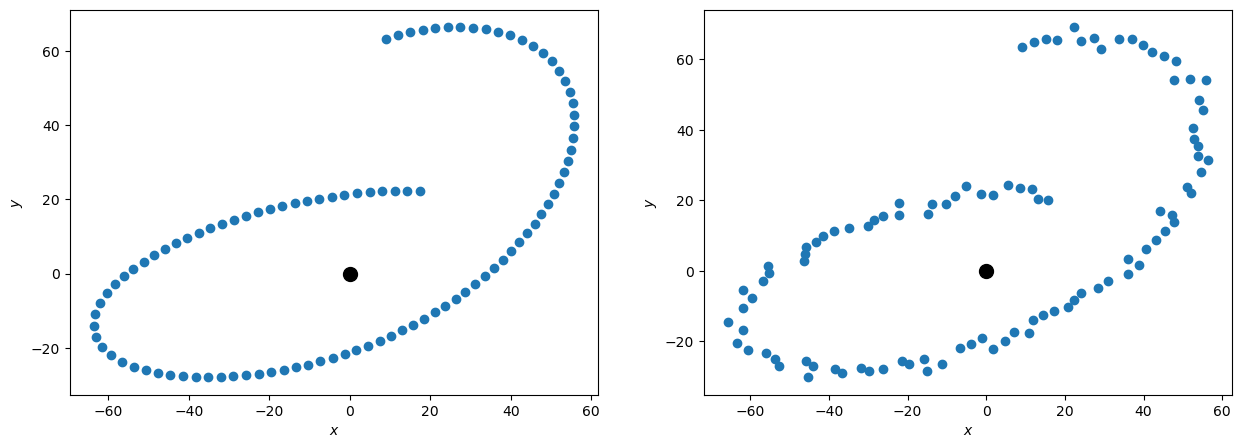

In [2]:
clean_data, dirty_data, sigma = generate_data(data_type='radial')
dict_data = {'clean_data': clean_data, 'dirty_data': dirty_data, 'sigma': sigma}

# 5 for Potential
halo_mass     = 7.5e11# * u.Msun 
concentration = 20
flattening_xy  = 0.75
flattening_xz  = 1.25

# 6 for Initial Conditions
pos_init = [50, -30, 40]# * u.kpc 
vel_init = [90,100,80]# * u.km/u.s


# 3 for orientation
alpha, beta, charlie = 0.01, -0.5, 0.7

# 2 for rotation
aa, bb = -0.1, 0.3

# 1 for time
t_end = 2.75

### Run ###
theo_params     = (halo_mass, concentration, flattening_xy, flattening_xz, pos_init[0], pos_init[1], pos_init[2], vel_init[0], vel_init[1], vel_init[2], t_end, alpha, beta, charlie, aa, bb)

### Plot ###
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(clean_data[0], clean_data[1])
plt.scatter(0,0, c='k', s=100)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.subplot(1,2,2)
plt.scatter(dirty_data[0], dirty_data[1])
plt.scatter(0,0, c='k', s=100)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

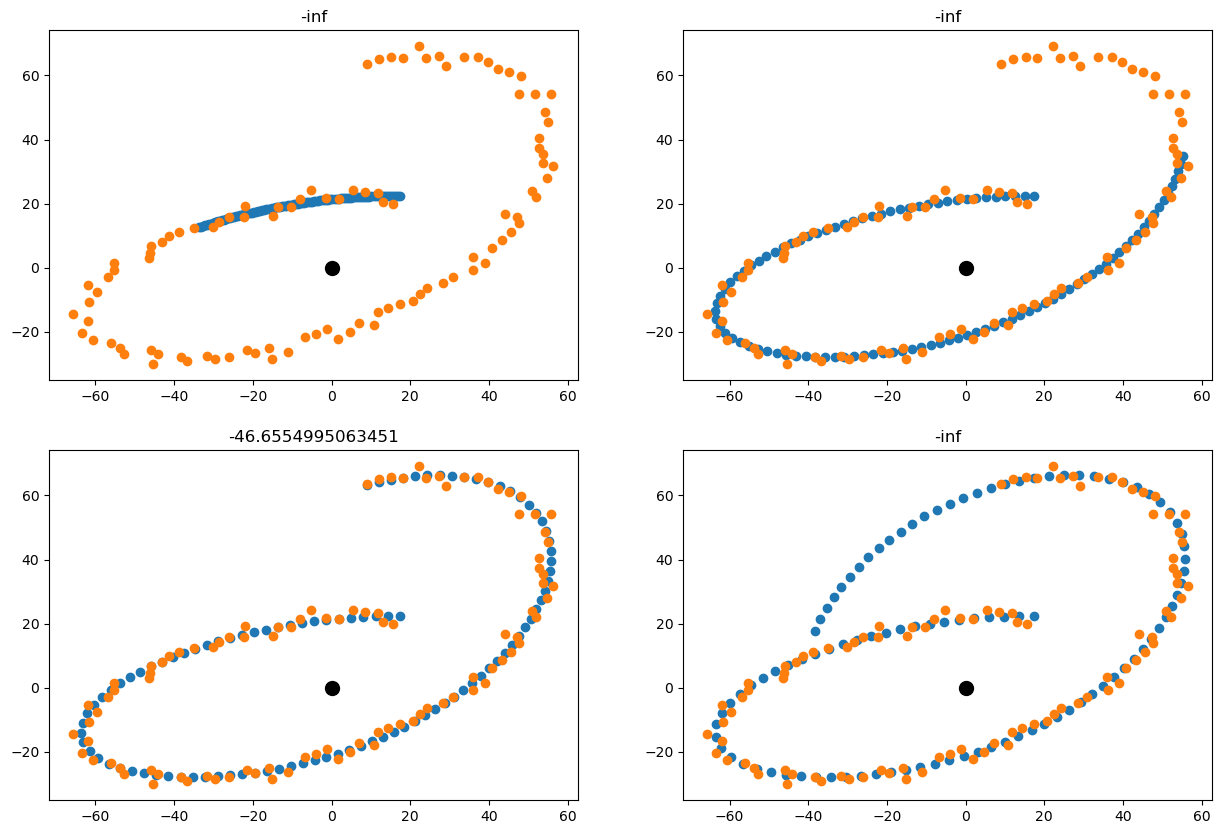

In [5]:
params_0 = np.array(theo_params)#.copy()
params_0[-6] = 0.4
model_0 = model(params_0)

params_1 = np.array(theo_params)#.copy()
params_1[-6] = 2
model_1 = model(params_1)

params_2 = np.array(theo_params)#.copy()
params_2[-6] = 2.75
model_2 = model(params_2)

params_3 = np.array(theo_params)#.copy()
params_3[-6] = 3.2
model_3 = model(params_3)

log_likelihood_function = log_likelihood_phi

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title(log_likelihood_function(params_0, dict_data))
plt.scatter(model_0[0], model_0[1])
plt.scatter(dirty_data[0], dirty_data[1])
plt.scatter(0,0, c='k', s=100)
plt.subplot(2,2,2)
plt.title(log_likelihood_function(params_1, dict_data))
plt.scatter(model_1[0], model_1[1])
plt.scatter(dirty_data[0], dirty_data[1])
plt.scatter(0,0, c='k', s=100)
plt.subplot(2,2,3)
plt.title(log_likelihood_function(params_2, dict_data))
plt.scatter(model_2[0], model_2[1])
plt.scatter(dirty_data[0], dirty_data[1])
plt.scatter(0,0, c='k', s=100)
plt.subplot(2,2,4)
plt.title(log_likelihood_function(params_3, dict_data))
plt.scatter(model_3[0], model_3[1])
plt.scatter(dirty_data[0], dirty_data[1])
plt.scatter(0,0, c='k', s=100)

Text(0, 0.5, '$y$')

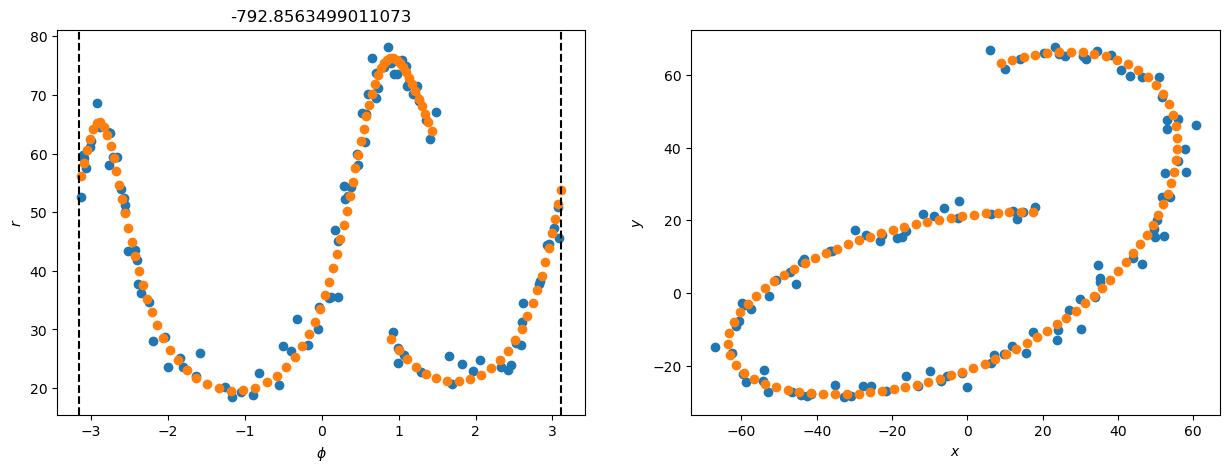

In [4]:
count  = 16
utheta = np.random.rand(count)
params = theo_params #prior_transform(utheta) 

model_data = model(params)

r_data = np.sqrt(dirty_data[0]**2 + dirty_data[1]**2)
phi_data = np.arctan2(dirty_data[1], dirty_data[0])

r_model = np.sqrt(model_data[0]**2 + model_data[1]**2)
phi_model = np.arctan2(model_data[1], model_data[0])

# Based on FOV of data
padding = 0.01
sign_min, sign_max = phi_data.min()/abs(phi_data.min()), phi_data.max()/abs(phi_data.max())

if sign_min < 0:
    phi_min_limit = phi_data.min()*(1+padding)
elif sign_min > 0:
    phi_min_limit = phi_data.min()*(1-padding)
else:
    phi_min_limit = phi_data.min()
if sign_max < 0:
    phi_max_limit = phi_data.max()*(1-padding)
elif sign_max > 0:
    phi_max_limit = phi_data.max()*(1+padding)
else:
    phi_max_limit = phi_data.max()

arg_in  = np.where( (phi_model.min() < phi_data) &  (phi_data < phi_model.max()) )[0]
arg_out = np.where( (phi_model < phi_min_limit) &  (phi_model > phi_max_limit) )[0]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title(log_likelihood_prob(params, dict_data))
plt.scatter(phi_data, r_data)
plt.scatter(phi_model, r_model)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$r$')
plt.axvline(phi_min_limit, c='k', ls='--')
plt.axvline(phi_max_limit, c='k', ls='--')
plt.subplot(1,2,2)
plt.scatter(r_data*np.cos(phi_data), r_data*np.sin(phi_data))
plt.scatter(r_model*np.cos(phi_model), r_model*np.sin(phi_model))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

In [98]:
import pickle

# Fixed Time step
with open('dynesty_results.pkl', 'rb') as file:
    results_10 = pickle.load(file)

with open('dynesty_results_Nt100.pkl', 'rb') as file:
    results_100 = pickle.load(file)

with open('dynesty_results_Nt1000.pkl', 'rb') as file:
    results_1000 = pickle.load(file)

# Fixed Distance step
with open('dynesty_results_Nt10_gamma.pkl', 'rb') as file:
    results_10_gamma = pickle.load(file)   

with open('dynesty_results_Nt100_gamma.pkl', 'rb') as file:
    results_100_gamma = pickle.load(file)

with open('dynesty_results_Nt100_density.pkl', 'rb') as file:
    results_100_density = pickle.load(file)

with open('dynesty_results_Nt100_phi.pkl', 'rb') as file:
    results_100_phi = pickle.load(file)

with open('dynesty_results_Nt100_phi_fill0.pkl', 'rb') as file:
    results_100_phi_fill0 = pickle.load(file)

with open('dynesty_results_Nt100_phi_fillMinMax.pkl', 'rb') as file:
    results_100_phi_fillMinMax = pickle.load(file)
    
with open('dynesty_results_Nt100_prob_punishLength.pkl', 'rb') as file:
    results_100_prob_punishLength = pickle.load(file)

with open('dynesty_results_Nt100_prob_NOpunish.pkl', 'rb') as file:
    results_100_prob_NOpunish = pickle.load(file)

with open('dynesty_results_N100_GMM.pkl', 'rb') as file:
    results_100_GMM = pickle.load(file)

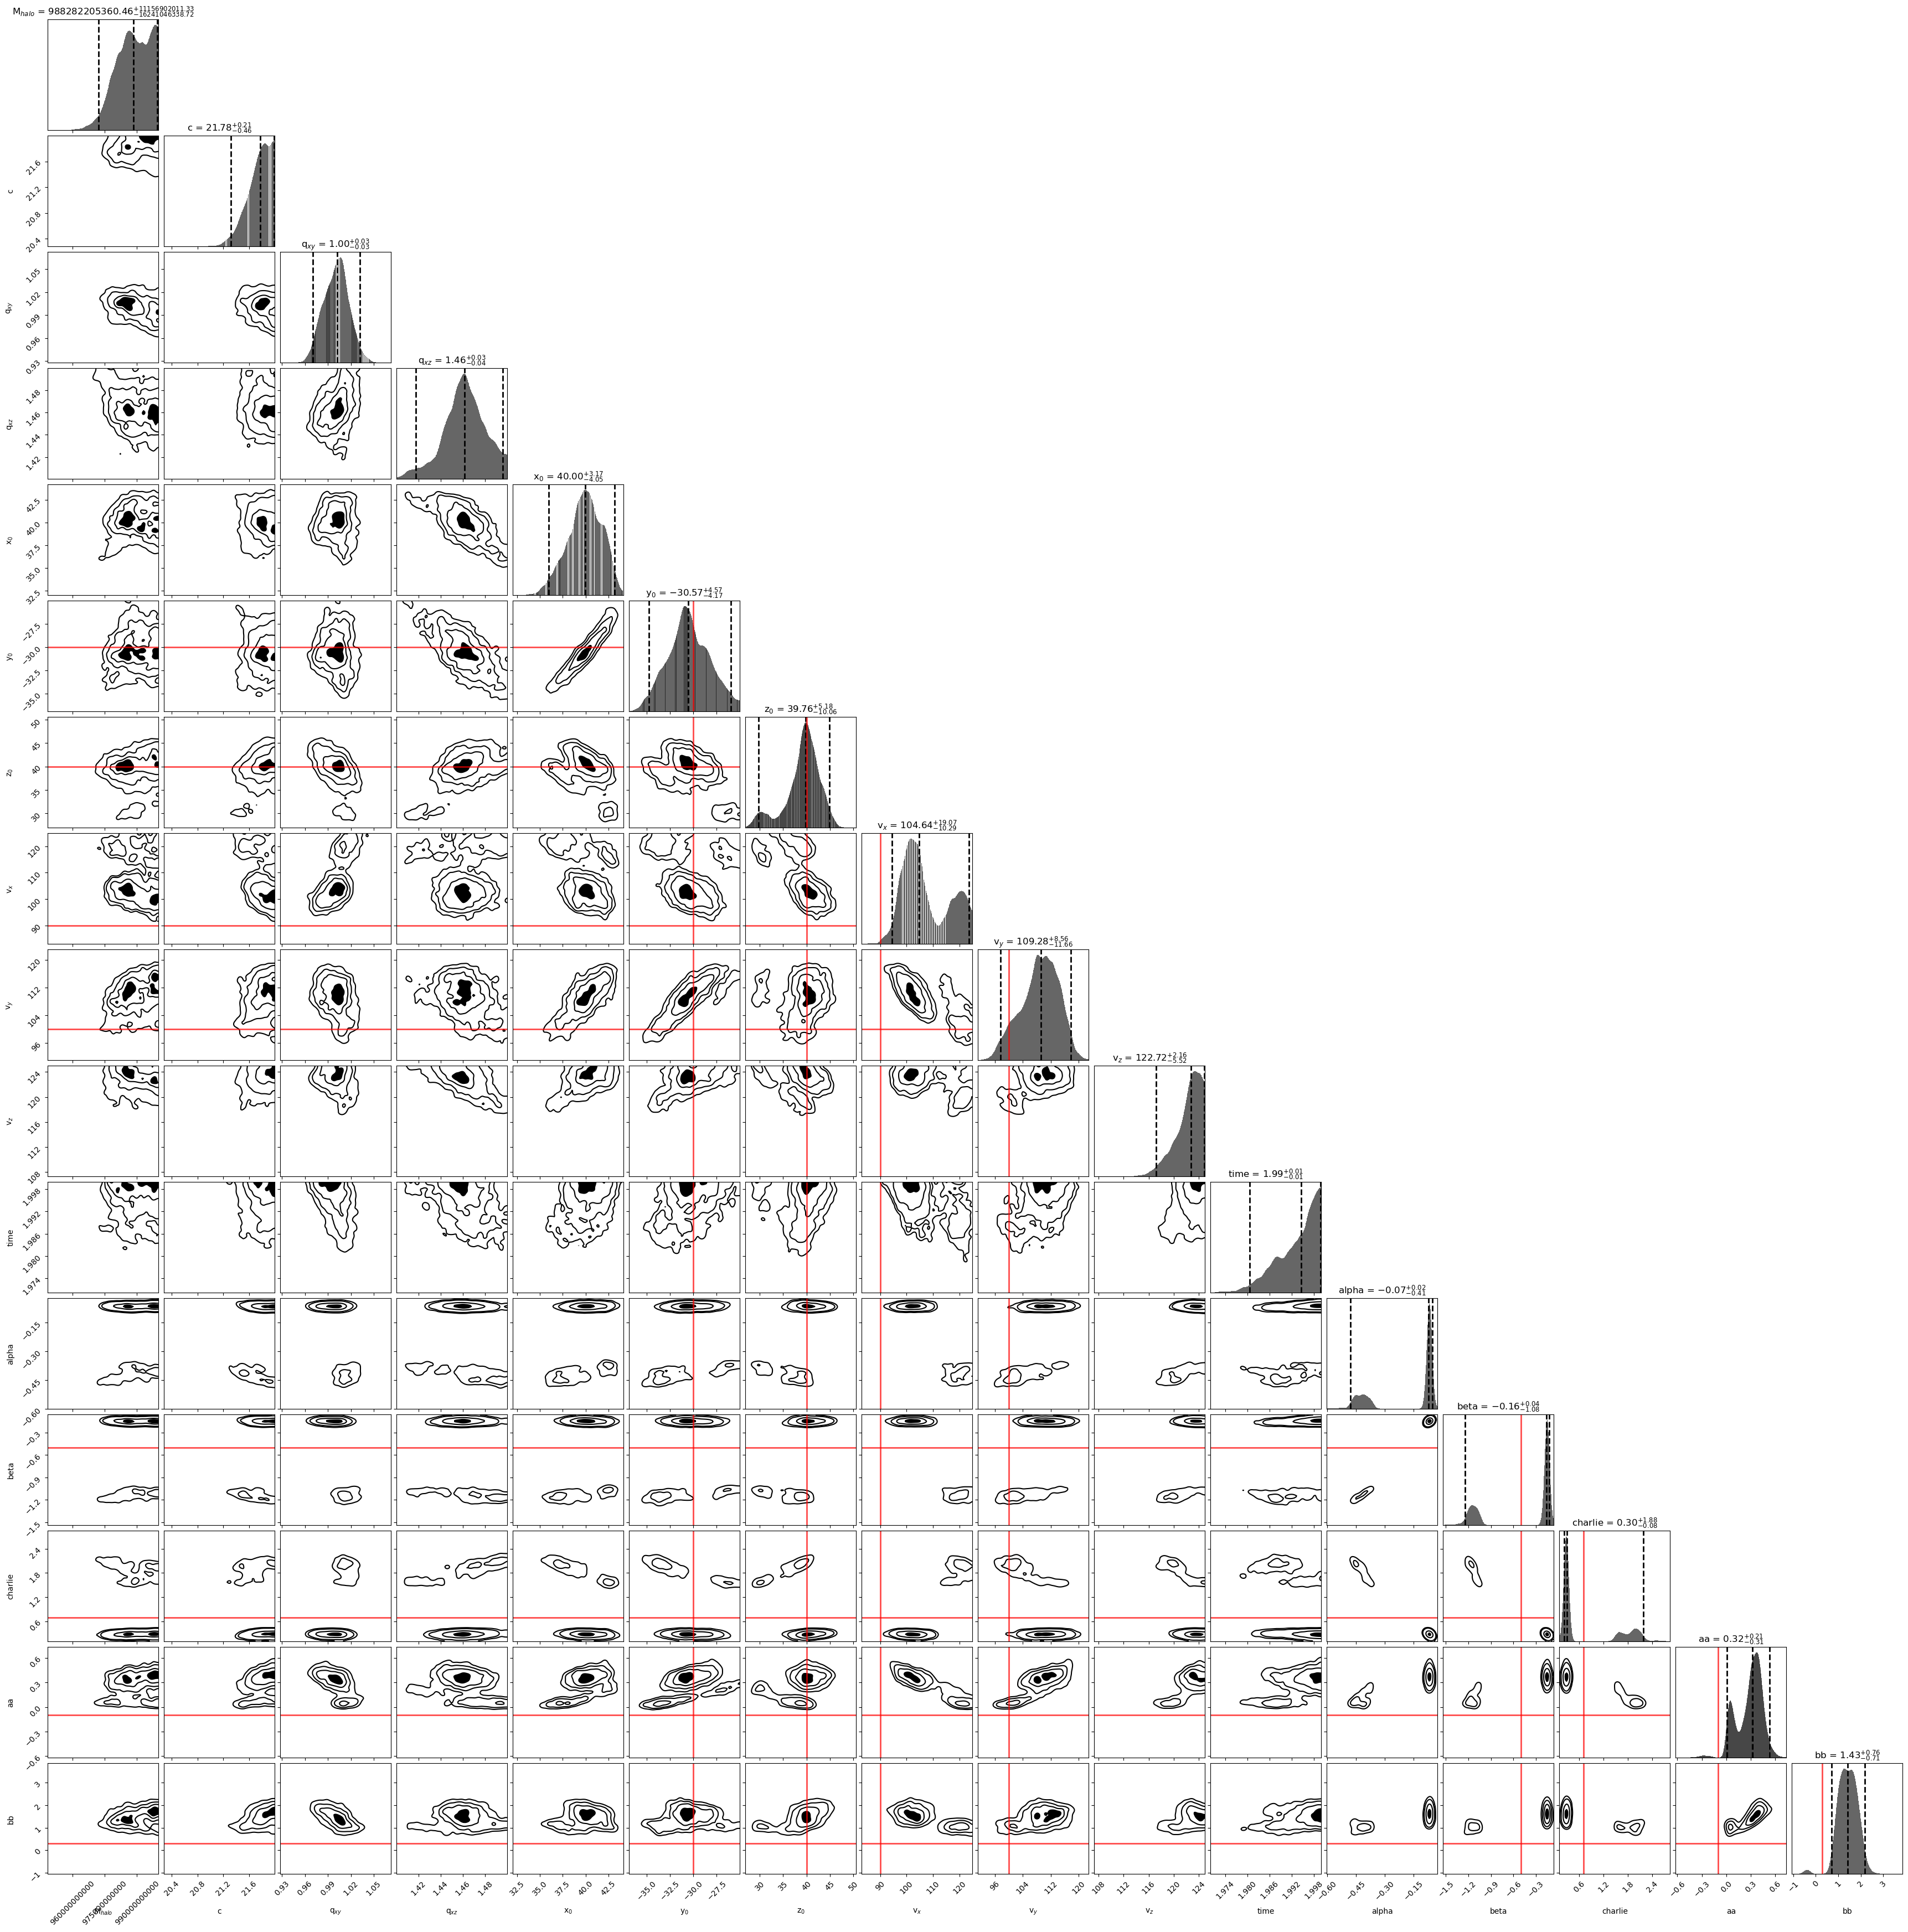

In [99]:
from dynesty import plotting as dyplot

results = results_100_GMM

# Plot a subset of parameters
labels = [r'M$_{halo}$', 'c', r'q$_{xy}$', r'q$_{xz}$', r'x$_0$', r'y$_0$', r'z$_0$', r'v$_x$', r'v$_y$', r'v$_z$', 'time', 'alpha', 'beta', 'charlie', 'aa', 'bb']
truths = [halo_mass, concentration, flattening_xy, flattening_xz, pos_init[0], pos_init[1], pos_init[2], vel_init[0], vel_init[1], vel_init[2], t_end, alpha, beta, charlie, aa, bb]
fig, axes = dyplot.cornerplot(results, truths=truths, labels=labels, show_titles=True)

In [109]:
weights.shape

(23545,)

In [100]:
# Extract weighted samples
samples = results.samples
weights = np.exp(results.logwt - results.logz[-1])

# Compute the weighted mean of the samples
mean_fit_params = np.sum(samples * weights.reshape(-1, 1), axis=0) / np.sum(weights)

# Compute the maximum log-likelihood
max_logl_index = np.argmax(results.logl)
max_logl_sample = results.samples[max_logl_index]
max_logl_value = results.logl[max_logl_index]
print(max_logl_value)

-822.2661627094766


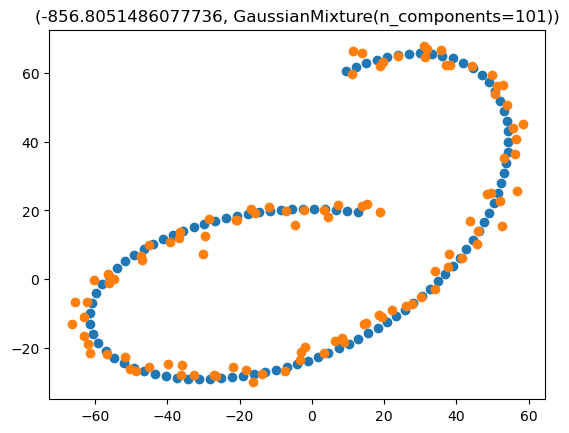

In [107]:
max_fit = model(max_logl_sample)

plt.title(log_likelihood_GMM(max_logl_sample, dict_data))
plt.scatter(max_fit[0], max_fit[1])
plt.scatter(dirty_data[0], dirty_data[1])

NameError: name 'phi_data' is not defined

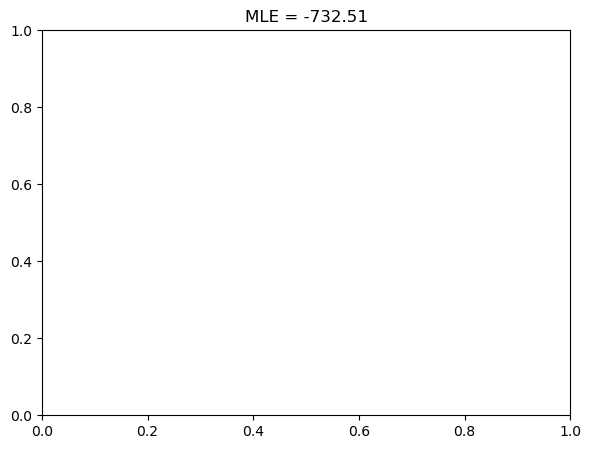

In [13]:
mean_fit = model(mean_fit_params)
max_fit = model(max_logl_sample)

r_mean, phi_mean = np.sqrt(mean_fit[0]**2 + mean_fit[1]**2), np.arctan2(mean_fit[1], mean_fit[0])
r_max, phi_max = np.sqrt(max_fit[0]**2 + max_fit[1]**2), np.arctan2(max_fit[1], max_fit[0])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title(f'MLE = {max_logl_value:.2f}')
plt.scatter(phi_data, r_data, color='b', label='Data')
plt.plot(phi_model, r_model, color='k', label='Truth', lw=5)
plt.scatter(phi_max, r_max, color='r', label='MLE')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$r$')
plt.axvline(phi_min_limit, c='k', ls='--')
plt.axvline(phi_max_limit, c='k', ls='--')
plt.legend(loc='upper left')
plt.subplot(1,2,2)
plt.scatter(r_data*np.cos(phi_data), r_data*np.sin(phi_data), color='b', label='Data')
plt.plot(r_model*np.cos(phi_model), r_model*np.sin(phi_model), color='k', label='Truth', lw=5)
plt.scatter(r_max*np.cos(phi_max), r_max*np.sin(phi_max), color='r', label='MLE')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend(loc='best')

In [ ]:
dirty_phi = np.arctan2(xy_dirty_data[1],xy_dirty_data[0])
f(dirty_phi)

array([        nan, 67.11857922, 66.57322514, 66.80818109, 67.0203528 ,
       67.18855949, 66.97731507, 67.13634074, 67.19031542, 67.1729448 ,
       66.77267582, 67.11288562, 66.66330479, 65.79071778, 65.89162999,
       67.02166799, 65.33636409, 66.00156708, 66.3167322 , 65.33053748,
       65.49897621, 65.17629523, 64.05531624, 64.59988174, 62.29307571,
       61.73501499, 61.40067068, 63.28474478, 61.96350521, 63.26135427,
       60.62829549, 61.0741792 , 61.35121769, 61.76142663, 60.25481809,
       57.95596772, 59.35644607, 58.86084713, 60.44579255, 57.81565258,
       56.975209  , 54.48149285, 56.91898914, 55.48080002, 57.75121928,
       55.04444655, 54.46973553, 52.69795036, 50.62709606, 50.27255464,
       52.99188863, 53.21941409, 49.75468662, 52.34994378, 49.39714332,
       48.38884283, 52.45665314, 51.02254921, 51.37081178, 48.78507098,
       47.52622113, 47.32641917, 47.51737365, 46.25925711, 44.48866772,
       45.92803509, 44.66456043, 45.14182183, 42.57620049, 42.82

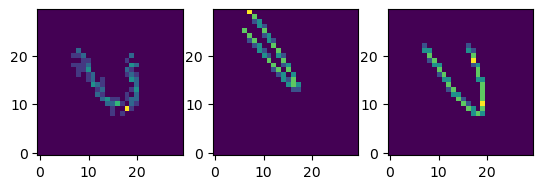

In [29]:
mean_fit = model(mean_fit_params)
max_fit = model(max_logl_sample)

# Based on FOV of data
x_min, x_max = -120, -20
y_min, y_max = 10, 100

# Based on spatial resolution
reso = 30

im_mean  = np.histogram2d(mean_fit[0], mean_fit[1], bins=reso, range=[[x_min, x_max], [y_min, y_max]])[0]
im_max   = np.histogram2d(max_fit[0], max_fit[1], bins=reso, range=[[x_min, x_max], [y_min, y_max]])[0]

plt.subplot(1,3,1)
plt.imshow(im_data, origin='lower')
plt.subplot(1,3,2)
plt.imshow(im_mean, origin='lower')
plt.subplot(1,3,3)
plt.imshow(im_max, origin='lower')

Text(0.5, 0, 'gamma')

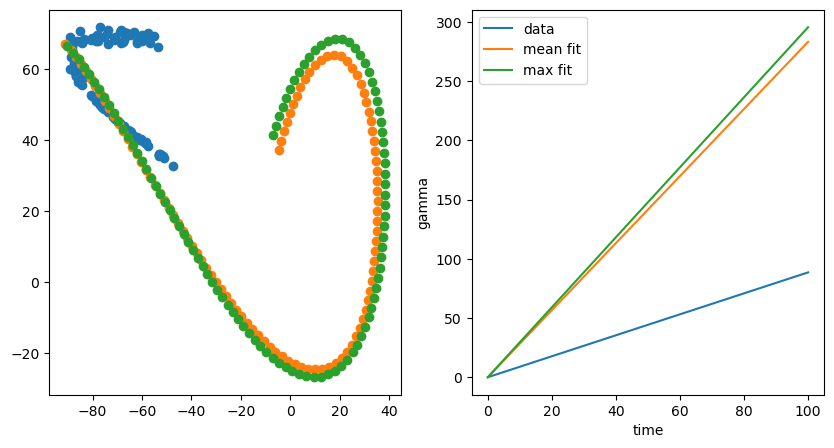

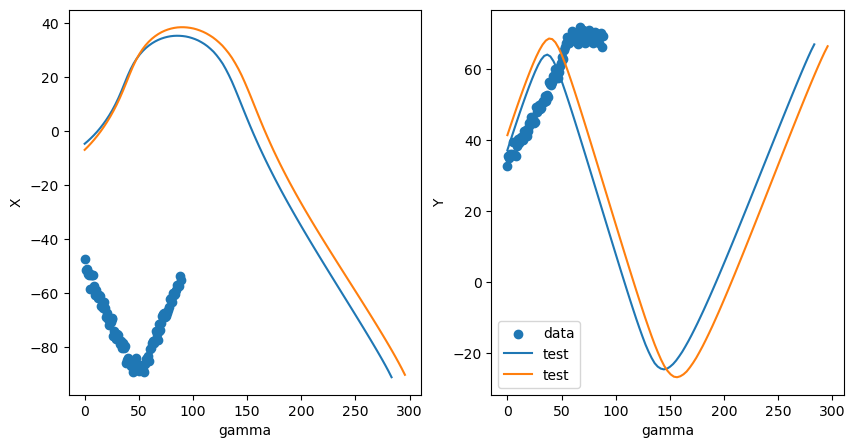

In [22]:
mean_fit = model(mean_fit_params)
max_fit  = model(max_logl_sample)

mean_fit_gamma = get_gamma(mean_fit)
max_fit_gamma  = get_gamma(max_fit)

data_gamma = get_gamma(clean_data)

if mean_fit_gamma[-1] < data_gamma[-1]:
    mean_fit_len_out = np.sum((data_gamma - mean_fit_gamma[-1]) > 0)
elif mean_fit_gamma[-1] > data_gamma[-1]:
    mean_fit_len_out = np.sum((mean_fit_gamma - data_gamma[-1]) > 0)

if max_fit_gamma[-1] < data_gamma[-1]:
    max_fit_len_out = np.sum((data_gamma - max_fit_gamma[-1]) > 0)
elif max_fit_gamma[-1] > data_gamma[-1]:
    max_fit_len_out = np.sum((max_fit_gamma - data_gamma[-1]) > 0)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dirty_data[0], dirty_data[1])
plt.scatter(mean_fit[0], mean_fit[1])
plt.scatter(max_fit[0], max_fit[1])
plt.subplot(1,2,2)
plt.plot(data_gamma, label='data')
plt.plot(mean_fit_gamma, label='mean fit')
plt.plot(max_fit_gamma, label='max fit')
plt.legend(loc='best')
plt.ylabel('gamma')
plt.xlabel('time')

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(data_gamma, dirty_data[0], label='data')
plt.plot(mean_fit_gamma, mean_fit[0], label='test')
plt.plot(max_fit_gamma, max_fit[0], label='test')
plt.ylabel('X')
plt.xlabel('gamma')
plt.subplot(1,2,2)
plt.scatter(data_gamma, dirty_data[1], label='data')
plt.plot(mean_fit_gamma, mean_fit[1], label='test')
plt.plot(max_fit_gamma, max_fit[1], label='test')
plt.legend(loc='best')
plt.ylabel('Y')
plt.xlabel('gamma')